<center><h1> Image Caption Generation </h1></center>

The idea behind this topic is to generate caption for a given image. Using this generated caption, select images which are similar to the input image using text similarity and provide the selected images as output.

In this project, we are going to use the two architectures of Deep Learning and they are CNN and RNN. CNN is usually used for image classification but works very well for image related operations. On the other hand, RNN is usually used to predict the sequence of things such as sentence, number and etc. So combining these two architectures, we are gonna create a system that is going to predict or generate image caption for an input image. 

<b><u> Methodology</u></b> 
<br>
I am gonna use a pre-trained model - <b>Xception</b> for extracting image features and LSTM i.e RNN will be using the data got from CNN to generate the descriptions.

<b><u>Dataset</u></b> 
<br>
I am going to use the following datasets for training and validation of the model
<ul>
    <li>Flickr_8K => contains images</li>
    <li>Flickr_8K_text => contains a file called flickr8k.token which contains the image and its respective token</li>
</ul>
<br>
<b><u>Libraries</u></b> <br>
<ul>
    <li> Keras </li>
    <li> NumPy </li>
    <li> Pickle </li>
    <li> String </li>
</ul>

In [1]:
import numpy as np #to perform numerical calculations
from PIL import Image #to read images
import os #to read contents from a directory in a system
from pickle import dump, load #to load or save files, models, features and etc.
import string #to preprocess captions
from pickle import load,dump #to load or dump files
import matplotlib.pyplot as plt

### Preprocessing

In [2]:
#Reading images and its corresponding captions
file = open("Data/Flickr8k_text/Flickr8k.token.txt","r")
caption_image_data = file.readlines()
caption_image_dict = {}
for data in caption_image_data:
    temp = data.split("\t") #splitting data based on tab space
    img_name = temp[0].split("#")[0].strip("\'") #getting image name as text
    captions = temp[1].rstrip().strip("\'") #getting caption
    
    #Preprocessing
    captions = captions.split() #converting caption into list of words for preprocessing
    captions = [caption.lower() for caption in captions] #converting each word into lowercase
    captions = [caption for caption in captions if caption not in string.punctuation] #filtering the words which are not in punctuation list
    captions = [caption for caption in captions if(len(caption)>1)] #removing a, 's, etc.
    captions = [caption for caption in captions if(caption.isalpha())] #getting only text and not numbers
    captions = " ".join(captions) #joining the final list of words into one sentence
    
    #creating a dict of image name and its corresponding 5 sentences
    if(img_name not in caption_image_dict):
        caption_image_dict[img_name] = [captions]
    else:
        caption_image_dict[img_name].append(captions)

#creating a file with processed text and image name also creating a vocabulary.
vocab = set()
final_Lines = []
for imgName, caption_list in caption_image_dict.items():
    for captions in caption_list:
        for caption in captions.split():
            vocab.add(caption) #Creating vocabulary
        final_Lines.append(imgName+"\t"+captions)

final_Lines = "\n".join(final_Lines) #Joining the contents of the list by next line character
caption_file = open("Data/Flickr8k_text/Captions.txt","w")
caption_file.write(final_Lines) #writing the final data into a file for further process
caption_file.close() #closing the file

### Transfer Learning - Extracting features vector from all images

I am going to use Xception, a pre-trained image classification model to fetch the feature vectors i.e. important characterstics of all images in our dataset as vectors. This model was trained on Imagenet dataset with 1000 classes to classify. In this architecture, I am going to remove the last output layer = classification layer as it is not a classification task. This architecture take images of size 299 x 299 x 3 and outputs 2048 feature vectors. I am going to save this feature vectors as a file for future usage rather than running this architecture every time.

In [2]:
from keras.applications.xception import Xception
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [4]:
model = Xception( include_top=False, pooling='avg') #include_top is false because we don't want classification layer and pooling is to reduce the dimensional complexity

In [6]:
image_dir = "Data/Flicker8k_Dataset"
image_names = os.listdir(image_dir)
feature_vectors = {}
for img in image_names:
    image = Image.open(image_dir+"/"+img)#Loading images and resizing it
    image = image.resize((299,299)) #resizing image
    image = np.expand_dims(image, axis=0) #adding one more dimension to the image array
    image = image/127.5 #Normalizing
    image = image - 1.0 #Scaling
    
    feature_vectors[img] = model.predict(image) #extracting features

dump(feature_vectors, open("Data/Flicker8k_Dataset/features.p","wb")) #saving the features

### Loading input data for training

In [3]:
#Image and its respective captions
train_Image_path = "Data/Flickr8k_text/Flickr_8k.trainImages.txt"
image_file = open(train_Image_path,"r")
train_image_data = image_file.readlines()
photos = []
for img in train_image_data:
    photos.append(img.split("\n")[0].rstrip().strip("\'")) #almost 12000 images for training

cleaned_caption_path = "Data/Flickr8k_text/Captions.txt"
caption_file = open(cleaned_caption_path,"r")
caption_data = caption_file.readlines()

final_caption_data = {}
for data in caption_data:
    temp = data.split("\n")[0].split()
    if(len(temp)<1):
        continue
    image_name, image_desc = temp[0], temp[1:]
    
    if(image_name in photos):
        if(image_name not in final_caption_data):
            final_caption_data[image_name] = []
        caption = "<start> "+" ".join(image_desc)+" <end>"
        final_caption_data[image_name].append(caption)

In [4]:
#image's feature vectors
feature_vector = load(open("Data/Flicker8k_Dataset/features.p","rb"))
feature_dict = {}
for photo in photos:
    feature_dict[photo] = feature_vector[photo]

In [5]:
#Vocabulary Tokenization
from keras.preprocessing.text import Tokenizer

captions_List = []
for key in final_caption_data.keys():
    [captions_List.append(d) for d in final_caption_data[key]]
    
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions_List)
dump(tokenizer, open('Data/Flickr8k_text/tokenized_text.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size #7264

#maximum length of captions is need to set the model parameters
max_length = max(len(cap.split()) for cap in captions_List)
max_length

33

We now need to format the input data that can be applied to a model for training, but having a huge size of data in memory and training on it is not a good practice. Hence, we need to make the data available in batches, so we need data generators which would make the data available for training in batches.

So our input consists of [X1,X2] where X1 is 2048 feature vector for image and X2 is embeddings for the captions of that image for 6000 images and output is text sequence.

In [7]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def generate_Data(captions, feat, tokenizer,max_Length,vocabulary_size):
    x1 = [] # image features
    x2 = [] # Sequence of texts
    y = [] #output sequence of texts
    for imageName,captionList in captions.items():
        image_feature = feat[imageName][0]
        for descriptions in captionList:
            sequences = tokenizer.texts_to_sequences([descriptions])[0]
            for i in range(1,len(sequences)):
                in_sequence, out_sequence = sequences[:i], sequences[i]
                in_sequence = pad_sequences([in_sequence], maxlen=max_Length)[0]
                out_sequence = to_categorical([out_sequence], num_classes=vocabulary_size)[0]
                x1.append(image_feature)
                x2.append(in_sequence)
                y.append(out_sequence)
    return np.array(x1),np.array(x2),np.array(y)

In [8]:
input_1,input_2,output = generate_Data(final_caption_data, feature_dict, tokenizer, max_length,vocab_size)
input_1.shape, input_2.shape, output.shape

((357116, 2048), (357116, 33), (357116, 7803))

### Loading input data for testing

In [9]:
#Image and its respective captions
test_Image_path = "Data/Flickr8k_text/Flickr_8k.testImages.txt"
image_file = open(test_Image_path,"r")
test_image_data = image_file.readlines()
photos_test = []
for img in test_image_data:
    photos_test.append(img.split("\n")[0].rstrip().strip("\'"))

cleaned_caption_path = "Data/Flickr8k_text/Captions.txt"
caption_file = open(cleaned_caption_path,"r")
caption_test_data = caption_file.readlines()

final_caption_test_data = {}
for data in caption_test_data:
    temp = data.split("\n")[0].split()
    if(len(temp)<1):
        continue
    image_name, image_desc = temp[0], temp[1:]
    
    if(image_name in photos_test):
        if(image_name not in final_caption_test_data):
            final_caption_test_data[image_name] = []
        caption = "<start> "+" ".join(image_desc)+" <end>"
        final_caption_test_data[image_name].append(caption)

In [10]:
#image's feature vectors
feature_vector = load(open("Data/Flicker8k_Dataset/features.p","rb"))
feature_dict_test = {}
for photos in photos_test:
    feature_dict_test[photos] = feature_vector[photos]

In [11]:
input_2,input_3,output_2 = generate_Data(final_caption_test_data, feature_dict_test, tokenizer, max_length,vocab_size)
input_2.shape, input_3.shape, output_2.shape

((50634, 2048), (50634, 33), (50634, 7803))

### Model building

In [12]:
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

input1 = Input(shape=(2048,))
feature1 = Dropout(0.5)(input1)
feature2 = Dense(256, activation='relu')(feature1)

input2 = Input(shape=(max_length,))
seq1 = Embedding(vocab_size, 256, mask_zero=True)(input2)
seq2 = Dropout(0.5)(seq1)
seq3 = LSTM(256)(seq2)

decoder1 = add([feature2, seq3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input1, input2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 33)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 33, 256)      1997568     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
_______________________________________________________________________________________

In [13]:
from keras.callbacks import ModelCheckpoint
X1train, X2train, ytrain = generate_Data(final_caption_data, feature_dict, tokenizer, max_length,vocab_size)
X1test, X2test,ytest = generate_Data(final_caption_test_data, feature_dict_test, tokenizer, max_length,vocab_size)

filepath = 'Models/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# fit model
history = model.fit([X1train, X2train], ytrain, epochs=20, verbose=2, callbacks=[checkpoint],validation_data=([X1test, X2test], ytest))

Epoch 1/20

Epoch 00001: val_loss improved from inf to 3.79400, saving model to Models/model-ep001-loss4.281-val_loss3.794.h5
11160/11160 - 1081s - loss: 4.2808 - accuracy: 0.2582 - val_loss: 3.7940 - val_accuracy: 0.2970
Epoch 2/20

Epoch 00002: val_loss improved from 3.79400 to 3.64045, saving model to Models/model-ep002-loss3.619-val_loss3.640.h5
11160/11160 - 974s - loss: 3.6194 - accuracy: 0.3073 - val_loss: 3.6405 - val_accuracy: 0.3138
Epoch 3/20

Epoch 00003: val_loss improved from 3.64045 to 3.63960, saving model to Models/model-ep003-loss3.418-val_loss3.640.h5
11160/11160 - 973s - loss: 3.4178 - accuracy: 0.3212 - val_loss: 3.6396 - val_accuracy: 0.3221
Epoch 4/20

Epoch 00004: val_loss improved from 3.63960 to 3.63854, saving model to Models/model-ep004-loss3.321-val_loss3.639.h5
11160/11160 - 976s - loss: 3.3206 - accuracy: 0.3283 - val_loss: 3.6385 - val_accuracy: 0.3257
Epoch 5/20

Epoch 00005: val_loss did not improve from 3.63854
11160/11160 - 978s - loss: 3.2631 - accu

In [32]:
#print(history.history.items())

In [17]:
#dump(history.history, open('Models/history.p', 'wb'))

In [3]:
hist = load(open('Models/history.p',"rb"))

### Model Accuracy

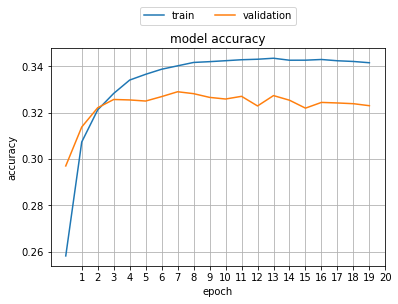

In [15]:
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xticks(np.arange(1, 21, 1))
plt.legend(['train', 'validation'], loc='center',bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.grid()
plt.show()

### Model Loss

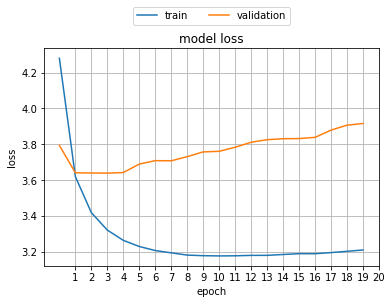

In [14]:
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(1, 21, 1))
plt.legend(['train', 'validation'], loc='center',bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.grid()
plt.show()